In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import warnings

# Setup
warnings.filterwarnings("ignore")

Challenge 1 - Loading and Evaluating The Data
In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

Examine the data using the head function.

In [2]:
phone = pd.read_csv(r"C:\Users\anato\Documents\IRONHACK\DAFT_1022\module_2\Lab_20_Time-Series-Analysis\sub_1.csv")
phone.head()

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [3]:
phone.isna().sum()

Unnamed: 0            0
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [4]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1751 non-null   int64  
 1   attitude.roll       1751 non-null   float64
 2   attitude.pitch      1751 non-null   float64
 3   attitude.yaw        1751 non-null   float64
 4   gravity.x           1751 non-null   float64
 5   gravity.y           1751 non-null   float64
 6   gravity.z           1751 non-null   float64
 7   rotationRate.x      1751 non-null   float64
 8   rotationRate.y      1751 non-null   float64
 9   rotationRate.z      1751 non-null   float64
 10  userAcceleration.x  1751 non-null   float64
 11  userAcceleration.y  1751 non-null   float64
 12  userAcceleration.z  1751 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 178.0 KB


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the pd.date_range function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in sensor. The frequency should be set to infer.

In [3]:
phone.index = pd.date_range('1/1/2018 00:00:00', '1/1/2018 00:29:10', freq = '1S')

In [8]:
phone.head()

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the statsmodels.api submodule and plot the decomposed plot of userAcceleration.x. Set freq=60 in the seasonal_decompose function. Your graph should look like the one below.

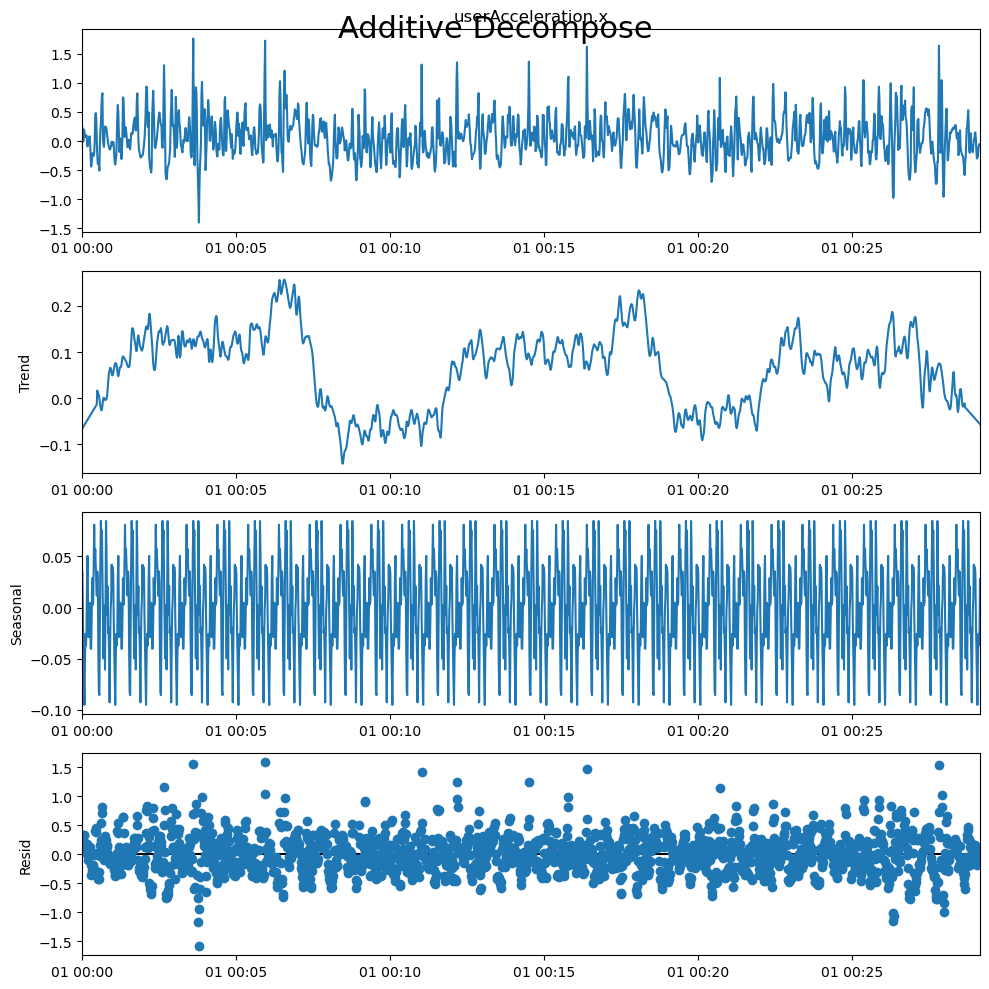

In [14]:
result = seasonal_decompose(phone['userAcceleration.x'], model = 'additive', period = 60, extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Plot the decomposed time series of rotationRate.x also with a frequency of 60.

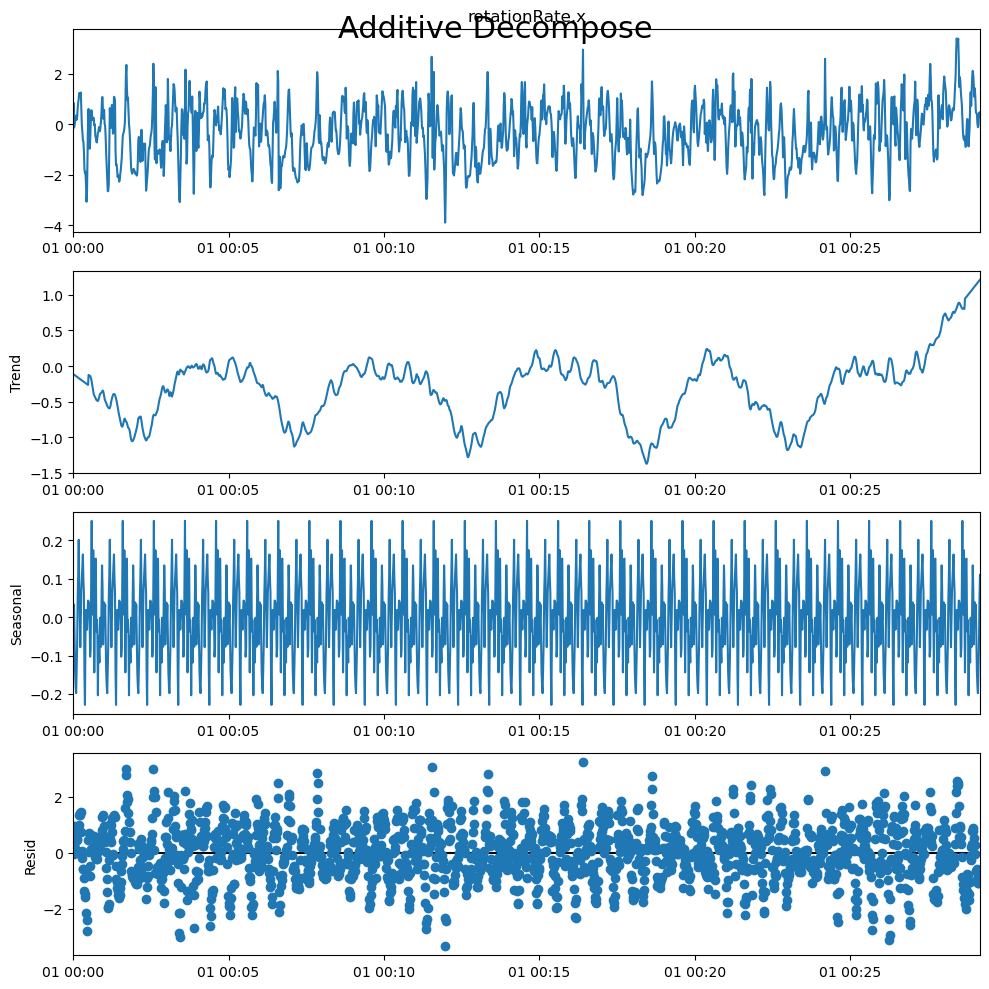

In [16]:
result_rot = seasonal_decompose(phone['rotationRate.x'], model = 'additive', period = 60, extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_rot.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Challenge 2 - Modelling the Data
To model our data, we should look at a few assumptions. First, let's plot the lag_plot to detect any autocorrelation. Do this for userAcceleration.x.

In [17]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

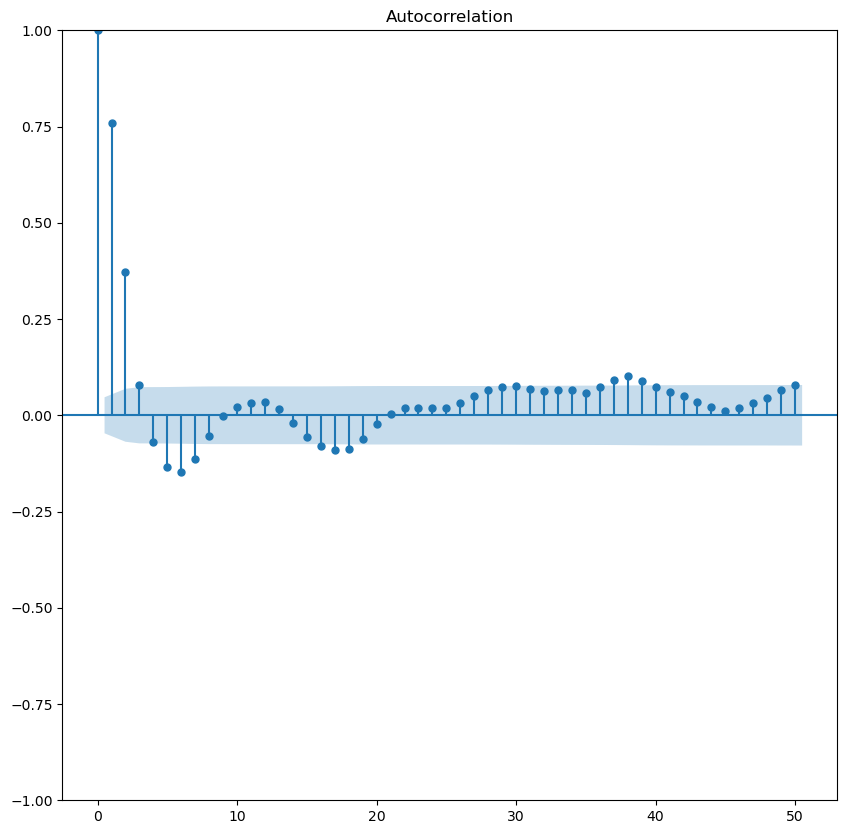

In [18]:
plot_acf(phone['userAcceleration.x'], lags = 50)
plt.show()

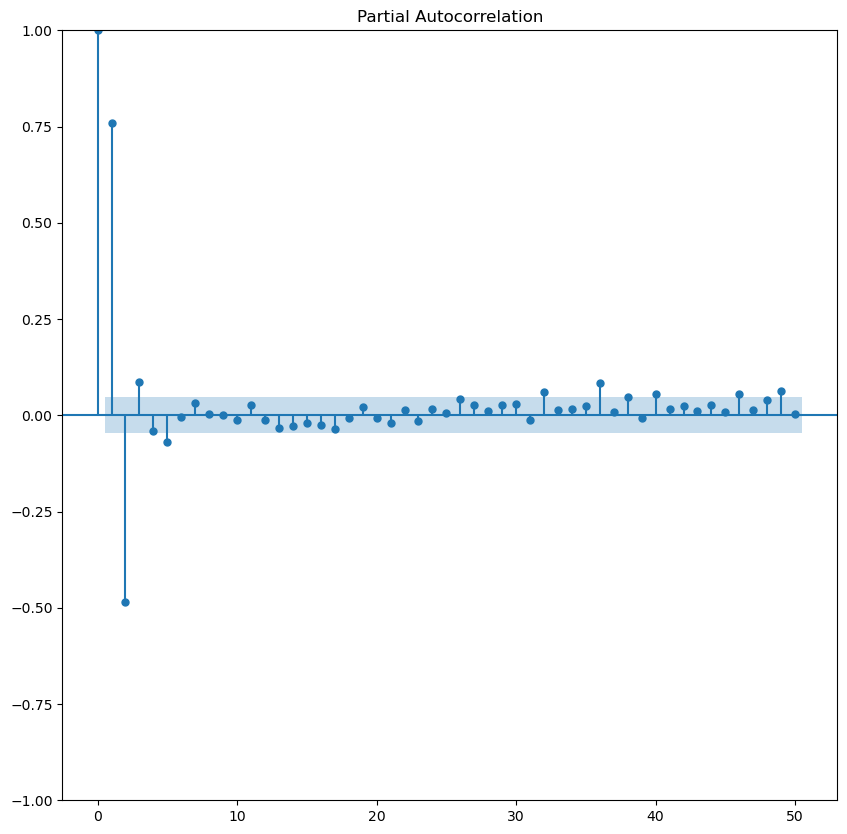

In [19]:
plot_pacf(phone['userAcceleration.x'], lags = 50)
plt.show()

Create a lag plot for rotationRate.x

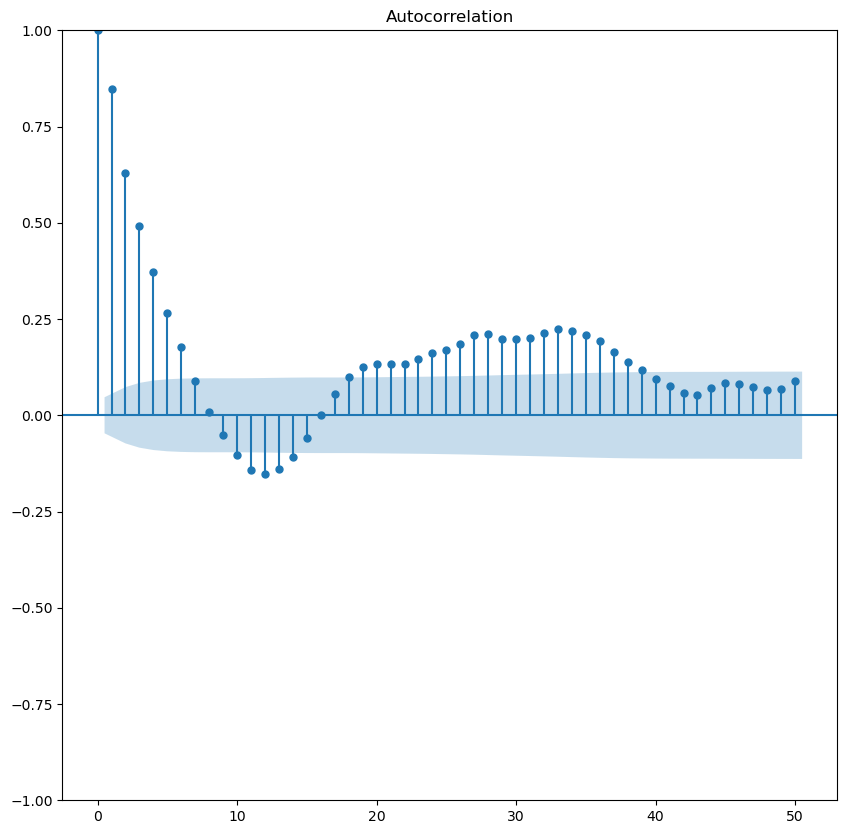

In [20]:
plot_acf(phone['rotationRate.x'], lags = 50)
plt.show()

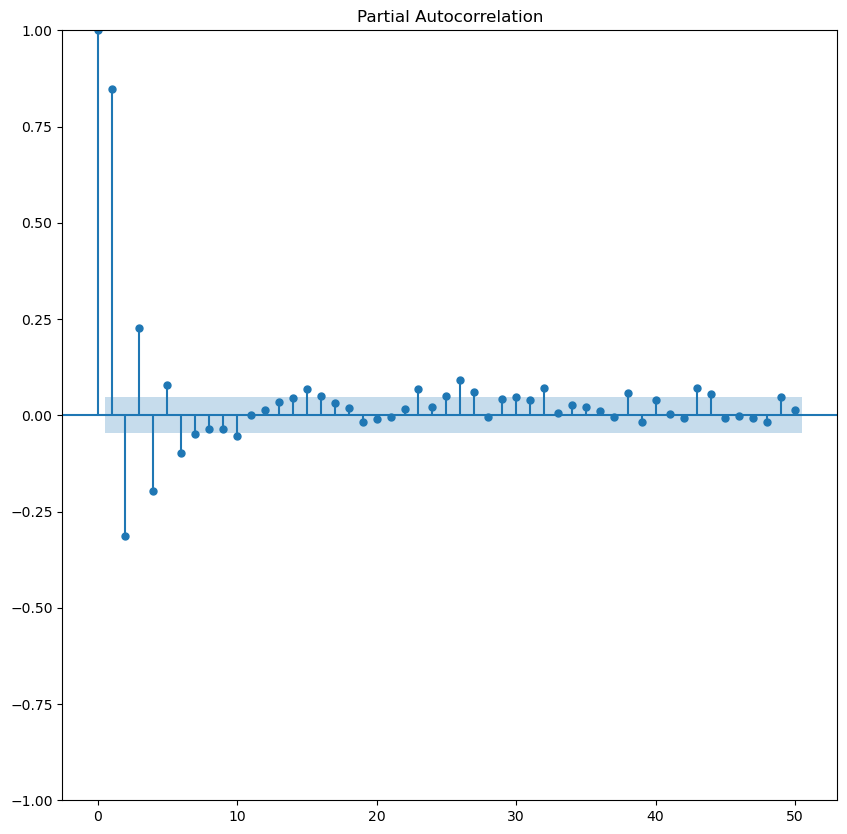

In [21]:
plot_pacf(phone['rotationRate.x'], lags = 50)
plt.show()

What are your conclusions from both visualizations?
There is correlation between user.acceleration and its lagged series by 1, 2 and 3s. There is correlation between rotation and its lagged series by 1 to 6s.

Comments: Autocorrelation in time series means that the series is linearly related to a lagged version of itself. For features 'rotationRate.x' and 'userAcceleration.x', the observations at time t have a positive linear correlation with the observations at time t+1. One of the assumptions of regression analysis is that the data has no autocorrelation. If we try to do a regression analysis on data with autocorrelation, then our analysis will be misleading.

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [22]:
adfuller(phone['userAcceleration.x'], autolag='AIC')

(-17.95799408616975,
 2.823439483037483e-30,
 4,
 1746,
 {'1%': -3.434100824760071,
  '5%': -2.863196780129223,
  '10%': -2.5676520210882936},
 -727.6140124402791)

In [23]:
adfuller(phone['rotationRate.x'], autolag='AIC')

(-5.269860625086399,
 6.320230335912861e-06,
 25,
 1725,
 {'1%': -3.4341465551936534,
  '5%': -2.863216966926812,
  '10%': -2.567662770090317},
 2619.6049719981947)

What are your conclusions from this test?

The p-values are very small in both cases. This means that we can reject the null hypothesis and conclude that these data are stationary.

Comments: ARMA models work on the assumption that the time series is stationary. Stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. In both cases, we can reject the null hypothesis that the time series is not stationary, so we can create an ARMA model.

Finally, we'll create an ARMA model for userAcceleration.x. Load the ARMA function from statsmodels. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set.

In [24]:
from statsmodels.tsa.arima_model import ARMA